In [1]:
import pandas as pd
import numpy as np
from scipy import stats # For in-built method to get PCC
import scipy
from sklearn.model_selection import KFold
import pingouin as pg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from zca import zca
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.tools
import matplotlib.pyplot as plt
zca = zca.ZCA()

In [2]:
target = 'Poverty'

all_data = pd.read_csv('../data/raw/states.csv')

scaler.fit(np.array(all_data[target]).reshape(-1, 1))

StandardScaler()

In [3]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
kfold.get_n_splits(all_data.index)

10

In [4]:
exclude = 'States'

sig_table = np.zeros(shape=(len(all_data.columns)))
signs_table = np.zeros(shape=(len(all_data.columns)))

p_threshold = .05

New_Names = all_data.columns[2:]
iteration = 0
for train_index, test_index in kfold.split(all_data):
    #print(iteration)
    max_pvalue = 1
    
    subset = all_data.iloc[train_index].loc[:, ~all_data.columns.isin([exclude])]
    
    #skip y and states
    set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    n=len(subset)
    
    while(max_pvalue>=.05):

        dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
        p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()[target]))).T
        p_values.columns = list(subset.columns)
        #print(p_values)
        
        #skip y
        max_pname = p_values.idxmax(axis=1)[0]
        
        max_pvalue = p_values[max_pname].values[0]
        
        if (max_pvalue > .05):
            #print(max_pname)
            #print(max_pvalue)
            set_.remove(max_pname)
            temp = [target]
            temp.extend(set_)
            subset = subset[temp]
    
    winners = p_values.loc[:, ~p_values.columns.isin([target])].columns.tolist()
    sig_table = (sig_table + np.where(all_data.columns.isin(winners),1,0)).copy()
    
    #signs_table = (signs_table + np.where(pd.DataFrame(subset.pcorr()[target])<0,-1,1)).copy()
    signs_table[all_data.columns.get_indexer(winners)]+=np.where(subset.pcorr()[target][winners]<0,-1,1)
    #print(winners)
    #print(max_pvalue)
    #iteration = iteration +1



In [5]:
significance = pd.DataFrame(sig_table).T
significance.columns = list(all_data.columns)
display(significance)

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,1.0,10.0,0.0,0.0,1.0,0.0,10.0,10.0,7.0


In [6]:
sign = pd.DataFrame(signs_table).T
sign.columns = list(all_data.columns)
display(sign)


,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,-1.0,-10.0,0.0,0.0,-1.0,0.0,10.0,-10.0,7.0


In [7]:
purity = abs((sign/num_folds)*(sign/significance)).T.replace([np.inf, -np.inf, np.NaN], 0)
display(purity.T)

,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
0,0.0,0.0,0.1,1.0,0.0,0.0,0.1,0.0,1.0,1.0,0.7


In [26]:
threshold = .6

chosen = list(purity.T.columns.values[np.array(purity.T>=threshold).reshape(len(all_data.columns,))])
dataSet = pd.concat([all_data[target],all_data[chosen]],axis=1)
y_scaled = pd.DataFrame(scaler.transform(np.array(dataSet[target]).reshape(-1, 1)))
y_scaled.columns=[target]


In [27]:
chosen

['White', 'Unemployed', 'Income', 'Population']

In [28]:
zca_data = pd.concat([y_scaled,pd.DataFrame(zca.fit_transform(dataSet[chosen]),columns=chosen)],axis=1)

In [29]:
zca_data.pcorr()

,Poverty,White,Unemployed,Income,Population
Poverty,1.000000,-0.603937,0.379943,-0.918181,0.359011
White,-0.603937,1.000000,0.229462,-0.554524,0.216820
Unemployed,0.379943,0.229462,1.000000,0.348857,-0.136404
Income,-0.918181,-0.554524,0.348857,1.000000,0.329637
Population,0.359011,0.216820,-0.136404,0.329637,1.000000


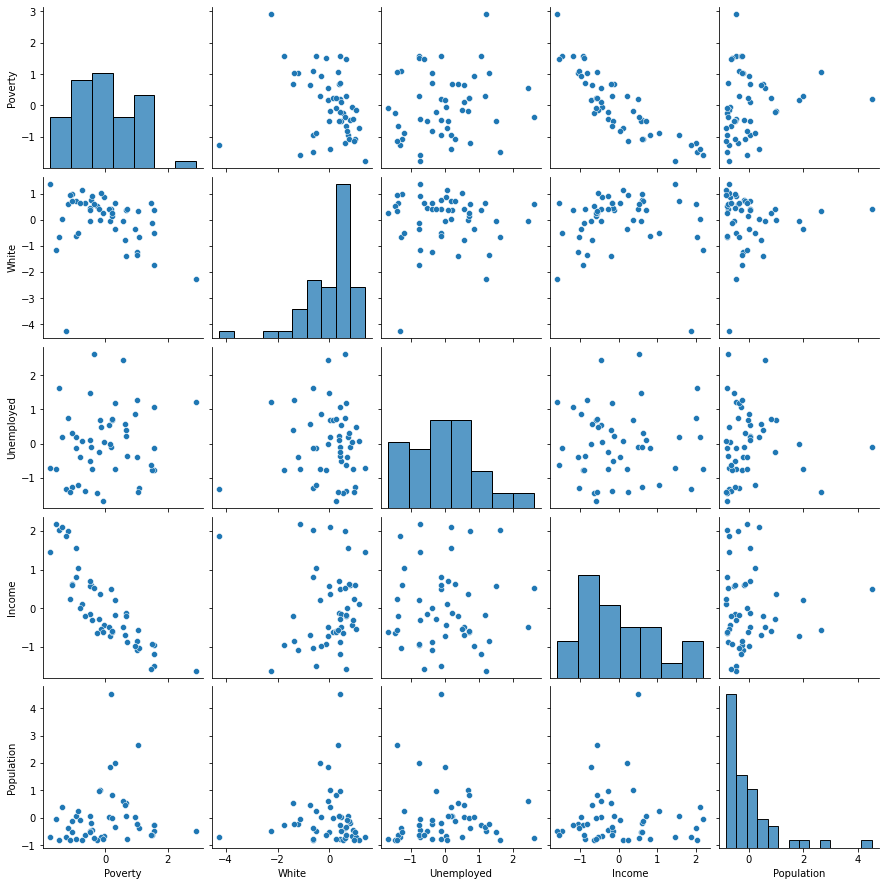

In [30]:
sns.pairplot(zca_data)

In [31]:

#model = sklearn.linear_model.LinearRegression()
data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
y = data_set_wConstant[target]
X = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(y,X)
results = model.fit()

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     70.45
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           8.61e-19
Time:                        17:13:18   Log-Likelihood:                -21.379
No. Observations:                  50   AIC:                             52.76
Df Residuals:                      45   BIC:                             62.32
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.743e-16      0.055   1.58e-14      1.000      -0.111       0.111
White         -0.2840      0.056     -5.083      0.000      -0.397      -0.171
Unemployed     0.1540      0.056      2.755      0.008       0.041       0.267
Income        -0.8688      0.056    -15.548      0.000      -0.981      -0.756
Population     0.1442      0.056      2.580      0.013       0.032       0.257
==============================================================================
Omnibus:                        2.601   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.357
Skew:                           0.442   Prob(JB):                        0.308
Kurtosis:                       2.409   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

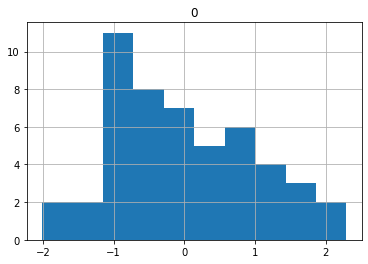

In [33]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

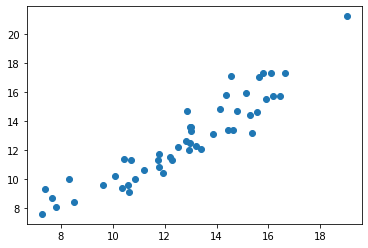

In [34]:
plt.scatter(results.fittedvalues*scaler.scale_[0] + scaler.mean_[0], y*scaler.scale_[0] + scaler.mean_[0])